In [3]:
%config Completer.use_jedi=False
%matplotlib inline

In [4]:
import time
import copy
import glob
import random
import multiprocessing

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [6]:
train_normal = glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\train\NORMAL\*")
train_pneumonia = glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\train\PNEUMONIA\*")

test_normal = glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\NORMAL\*")
test_pneumonia = glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\PNEUMONIA\*")

In [7]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [8]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [9]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [10]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths,
                                                                        train_labels,
                                                                        stratify = train_labels)

In [10]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10, 10))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    ax1.axis('off')  # Optional: hide axes

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")
    ax2.axis('off')  # Optional: hide axes

    plt.tight_layout()
    plt.show()


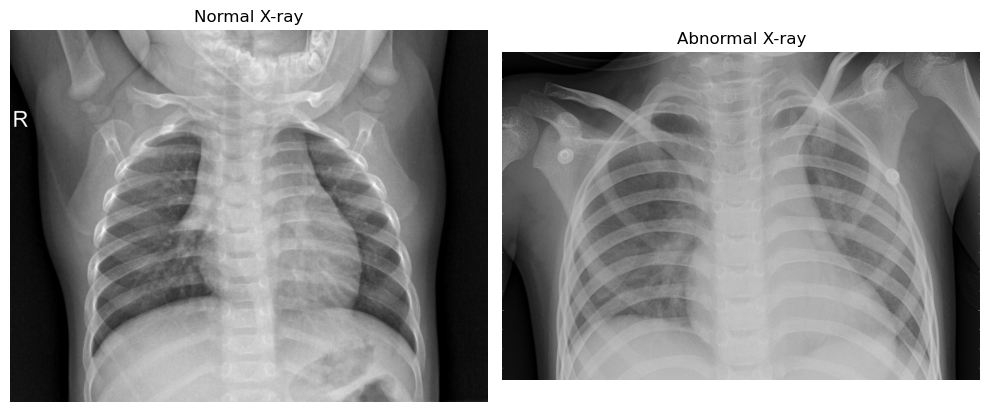

In [11]:
show_random_images()

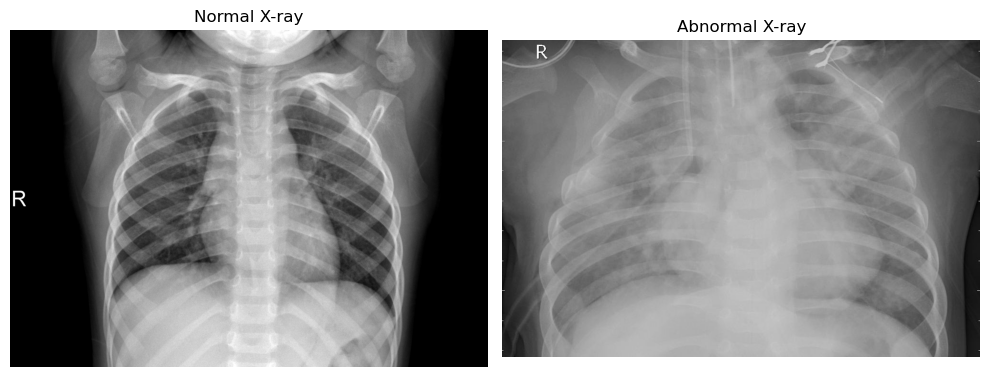

In [12]:
show_random_images()

In [13]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor([label])

        return image, label

In [14]:
resnet = resnet18()

In [15]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0), 512)
        x = self.fc(x)

        return x

        

In [16]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [17]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3
num_epochs = 2
train_batch_size = 8
valid_batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers = min(4, multiprocessing.cpu_count()), shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers = min(4, multiprocessing.cpu_count()), shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
def train_model(model, criterion, optimizer, num_epochs, device=device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                           leave=False,
                                           total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)

                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i + 1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i + 1) * batch_sizes[phase])

                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss: {avg_loss} | acc: {avg_acc}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since

    print(f"training took {time_elapsed} seconds")

    model.load_state_dict(best_model_wts)

    return model


In [ ]:
model = train_model(model, criterion, optimizer, num_epochs)

In [1]:
test_paths = glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\NORMAL\*") + glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\PNEUMONIA\*")
test_labels = [0] * len(glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\NORMAL\*")) + [1] * len(glob.glob(r"C:\Users\Felix\OneDrive\Documents\DeepLearning\data\test\PNEUMONIA\*"))

NameError: name 'glob' is not defined

In [12]:
len(test_paths), len(test_labels)

(624, 624)

In [ ]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False)

In [ ]:
y_pred = []
y_true = []

tensors = tensors.to(device)  
predictions = model(tensors)

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
  with torch.no_grad():
    predictions = model(tensors)
    predictions = predictions.sigmoid()
    predictions = predictions > 0.5
    y_pred.append(predictions)
    
    y_true.append(labels)

In [ ]:
y_pred[0]

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred.shape, y_true.shape,

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true, y_pred)